In [122]:
## IMPORTS ##
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import datetime as dt

import mwclient 
import time 
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

from textblob import TextBlob
import tweepy
import sys

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [123]:
## Getting the required dataset ##
# Initialize the exchange object for Binance
crypto_currency = 'BTC'           # Crpto currency we are intrested in 
currency = 'USD'                  # Value of Crypto in this particular currency

# Fetch historical data
ticker = yf.Ticker(f'{crypto_currency}-{currency}') 

# Convert to DataFrame
data = ticker.history(period = "max")

# Convert timestamp to datetime
data.index = pd.to_datetime(data.index)

print(data.info)

<bound method DataFrame.info of                                    Open          High           Low  \
Date                                                                  
2014-09-17 00:00:00+00:00    465.864014    468.174011    452.421997   
2014-09-18 00:00:00+00:00    456.859985    456.859985    413.104004   
2014-09-19 00:00:00+00:00    424.102997    427.834991    384.532013   
2014-09-20 00:00:00+00:00    394.673004    423.295990    389.882996   
2014-09-21 00:00:00+00:00    408.084991    412.425995    393.181000   
...                                 ...           ...           ...   
2024-04-21 00:00:00+00:00  64992.816406  65723.242188  64277.722656   
2024-04-22 00:00:00+00:00  64935.632812  67233.960938  64548.179688   
2024-04-23 00:00:00+00:00  66839.890625  67199.242188  65864.867188   
2024-04-24 00:00:00+00:00  66408.718750  67075.367188  63589.871094   
2024-04-26 00:00:00+00:00  64482.996094  64595.386719  63988.210938   

                                  Close     

In [124]:
## Getting Wikipedia Edits ##
site = mwclient.Site("en.wikipedia.org")
page = site.pages["Bitcoin"]

revs = list(page.revisions())

revs = sorted(revs, key = lambda rev : rev['timestamp'] )[16019:]  # Data from the last 5 years

print(revs[0])

OrderedDict([('revid', 902801671), ('parentid', 902785988), ('user', 'Ladislav Mecir'), ('timestamp', time.struct_time(tm_year=2019, tm_mon=6, tm_mday=21, tm_hour=10, tm_min=39, tm_sec=20, tm_wday=4, tm_yday=172, tm_isdst=-1)), ('comment', "Undid revision 902753266 by [[Special:Contributions/Jtbobwaysf|Jtbobwaysf]] ([[User talk:Jtbobwaysf|talk]]) rv., the marked citation does not cite Satoshi's whitepaper; it is an obviously unrelated article")])


In [29]:
## SENTIMENTIAL ALAYSIS Implemented ##

classifier = pipeline("sentiment-analysis")

def find_sentiment(text):
    text = text[:250]
    result = classifier(text)[0]
    score = result["score"]
    if result["label"] == "NEGATIVE":
        score *= -1
    return score

print(find_sentiment("I love you"))
print(find_sentiment("I hate you"))

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


0.9998656511306763
-0.9991129040718079


In [127]:
## Create Dataset ##

edits = {}

for rev in revs:
    date = time.strftime("%Y-%m-%d", rev["timestamp"])

    if date not in edits:
        edits[date] = dict(sentiments=list(), edit_count=0)
    
    edits[date]["edit_count"] += 1

    if "comment" in rev.keys():
        comment = rev["comment"]
        edits[date]["sentiments"].append(find_sentiment(comment))

for key in edits:
    if len(edits[key]["sentiments"]) > 0:
        edits[key]["sentiment"] = sum(edits[key]["sentiments"]) / len(edits[key]["sentiments"])
        edits[key]["neg_sentiment"] = len([s for s in edits[key]["sentiments"] if s< 0]) / len(edits[key]["sentiments"])
    else:
        edits[key]["sentiment"] = 0
        edits[key]["neg_sentiment"] = 0

    del edits[key]["sentiments"]

print(edits['2019-06-21'])

{'edit_count': 6, 'sentiment': -0.3009791572888692, 'neg_sentiment': 0.6666666666666666}


In [128]:
edits_df = pd.DataFrame.from_dict(edits, orient="index")
edits_df.index = pd.to_datetime(edits_df.index)

dates = pd.date_range(start="2019-04-01", end=dt.datetime.today().today())
edits_df = edits_df.reindex(dates, fill_value=0)

rolling_edits = edits_df.rolling(30).mean()
rolling_edits = rolling_edits.dropna()

In [129]:
print(rolling_edits.head)

<bound method NDFrame.head of             edit_count  sentiment  neg_sentiment
2019-04-30    0.000000   0.000000       0.000000
2019-05-01    0.000000   0.000000       0.000000
2019-05-02    0.000000   0.000000       0.000000
2019-05-03    0.000000   0.000000       0.000000
2019-05-04    0.000000   0.000000       0.000000
...                ...        ...            ...
2024-04-22    0.300000  -0.155494       0.183333
2024-04-23    0.300000  -0.155494       0.183333
2024-04-24    0.266667  -0.122210       0.150000
2024-04-25    0.266667  -0.122210       0.150000
2024-04-26    0.266667  -0.122210       0.150000

[1824 rows x 3 columns]>


In [130]:
## Creating the Final Data used in our ML Model ##

data.index = data.index.tz_localize(None)  # Removing timezone information if present (to prevent errors)
rolling_edits.index = rolling_edits.index.tz_localize(None)  # Removing timezone information if present

data = data.merge(rolling_edits, left_index=True, right_index=True)

data['Tomorrow'] = data['Close'].shift(-1)
data['Target'] = (data["Tomorrow"] > data["Close"]).astype(int)

print(data.head)

<bound method NDFrame.head of                     Open          High           Low         Close  \
2019-04-30   5247.726074   5363.257324   5224.189941   5350.726562   
2019-05-01   5350.914551   5418.003906   5347.645996   5402.697266   
2019-05-02   5402.422852   5522.262695   5394.217285   5505.283691   
2019-05-03   5505.552246   5865.881836   5490.201660   5768.289551   
2019-05-04   5769.202637   5886.893555   5645.469238   5831.167480   
...                  ...           ...           ...           ...   
2024-04-21  64992.816406  65723.242188  64277.722656  64926.644531   
2024-04-22  64935.632812  67233.960938  64548.179688  66837.679688   
2024-04-23  66839.890625  67199.242188  65864.867188  66407.273438   
2024-04-24  66408.718750  67075.367188  63589.871094  64276.898438   
2024-04-26  64482.996094  64595.386719  63988.210938  64363.828125   

                 Volume  Dividends  Stock Splits  edit_count  sentiment  \
2019-04-30  13878964574        0.0           0.0    0.

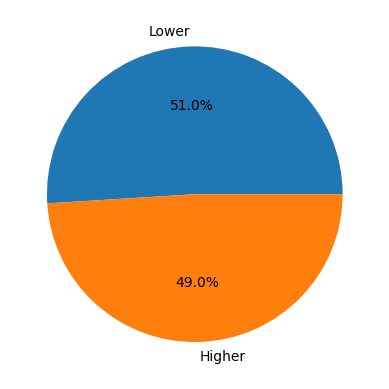

In [34]:
# Fun observation : 

plt.pie(data['Target'].value_counts().values, 
        labels=["Lower", "Higher"], autopct='%1.1f%%')
plt.show()

In [109]:
## Train Data ##
features = ['Close', 'sentiment', 'neg_sentiment']

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data[features].values)

prediction_days = 60

x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, :])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(features)))

## Neural Network ##
L0 = LSTM(units = 50, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2]))
L1 = Dropout(0.2)
L2 = LSTM(units = 50, return_sequences = True)
L3 = Dropout(0.2)
L4 = LSTM(units = 50)
L5 = Dropout(0.2)
L6 = Dense(units=1)

model = Sequential([L0, L1, L2, L3, L4, L5, L6])

opt = tf.keras.optimizers.Adam()

model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50


C:\Users\harsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 7.3612e-04 - loss: 0.0329 - val_accuracy: 0.0056 - val_loss: 0.0054
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 5.3568e-04 - loss: 0.0054 - val_accuracy: 0.0056 - val_loss: 0.0035
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 3.7247e-05 - loss: 0.0039 - val_accuracy: 0.0056 - val_loss: 0.0030
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.0015 - loss: 0.0042 - val_accuracy: 0.0056 - val_loss: 0.0051
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 6.6178e-04 - loss: 0.0033 - val_accuracy: 0.0056 - val_loss: 0.0027
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.0012 - loss: 0.0032 - val_accuracy: 0.0056 - val_loss: 0.0038
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.0016 - loss: 0.0034 - val_accuracy: 0.0056 - val_loss: 0.0053
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 1.7873e-04 - loss: 0.0030 - val_accuracy: 0

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


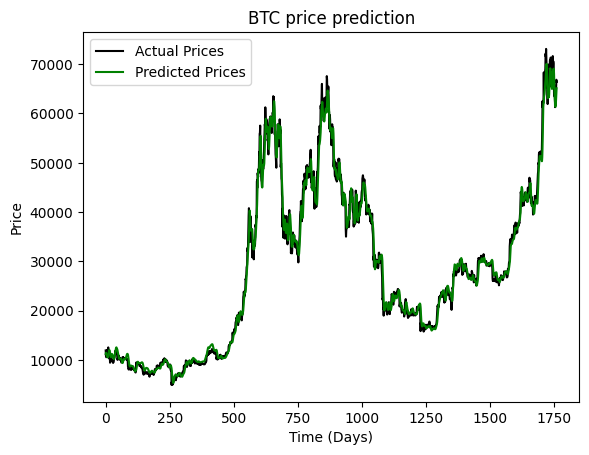

In [121]:
## Testing Data ##
testData = ticker.history(period="max")
testData.index = pd.to_datetime(testData.index)
testData.index = testData.index.tz_localize(None)  # Remove timezone information if present

testData = testData.merge(rolling_edits, left_index=True, right_index=True)

testData['Tomorrow'] = testData['Close'].shift(-1)
testData['Target'] = (testData["Tomorrow"] > testData["Close"]).astype(int)

testData = testData[:-1]  # Drop the last row since we don't have "Tomorrow" for it
testData = testData.dropna()

actual = testData['Close'].values

total_dataset = pd.concat((data[features], testData[features]), axis=0)

model_inputs = total_dataset[features][len(total_dataset) - len(testData) - prediction_days:].values
model_inputs = scaler.transform(model_inputs)

x_test, y_test = [], []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, :])
    y_test.append(model_inputs[x, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

## Reshape the input data for LSTM ##
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], len(features)))


## Prediction ##
prediction_prices = model.predict(x_test)
prediction_prices = np.concatenate((prediction_prices, np.zeros((prediction_prices.shape[0], len(features) - 1))), axis=1)
prediction_prices = scaler.inverse_transform(prediction_prices)  # Apply inverse transform


plt.plot(actual[60:], color='black', label='Actual Prices')
plt.plot(prediction_prices[60:, 0], color='green', label='Predicted Prices')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time (Days)')
plt.ylabel('Price')
plt.legend()
plt.show()

#### BREIF OBSERVATION : ####
It can be observed that their is a close similarity between the predicted and actual cryptocurrency prices, demostrating that our ML model works with good accuracy.

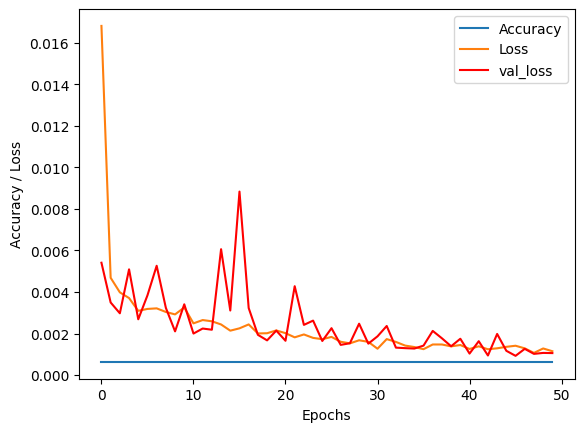

[0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.0006309148157015443, 0.00063091

In [120]:
## PLOT THE accuracy, loss, and val_loss metrics ##
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend(['Accuracy', 'Loss', 'val_loss'])
plt.show()

print(history.history['accuracy'])
print(history.history['loss'])
print(history.history['val_loss'])

#### BREIF OBSERVATION : ####
It can be observed that there is a consistent measure for accuracy but a fairly inconsistent distribution for both loss and val_loss which is expected due to the unpredictable nature of crypto, but regardless our model appears to be performing well and effectively

In [112]:
# Select the last 60 days of data for prediction
dataLast = scaled_data[-prediction_days:]

# Reshape the data for prediction
x_pred = np.array(dataLast)    
x_pred = np.reshape(x_pred, (1, x_pred.shape[0], len(features)))

predicted_price = model.predict(x_pred)

predicted_price = scaler.inverse_transform(np.concatenate((predicted_price, np.zeros((predicted_price.shape[0], len(features) - 1))), axis=1))

# Print the predicted price
print(f"The predicted price of {crypto_currency} today is: {data.iloc[-1]['Close']} {currency}")
print(f"The predicted price of {crypto_currency} tomorrow is: {predicted_price[0][0]} {currency}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
The predicted price of BTC today is: 64348.78515625 USD
The predicted price of BTC tomorrow is: 65256.20906840504 USD


#### Conclusion ####
Finally, we conclude by utilizing our developed model to compute the predicted value of the cryptocurrency for tomorrow.